In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when
from pyspark.sql.functions import count as spark_count
import seaborn as sns
import warnings
import contextlib

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

from sklearn.preprocessing import QuantileTransformer, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

In [0]:
file_path = "default.college_4_csv"

college_df = spark.table(file_path)
float_cols = ['Top10perc', 'Top25perc', 'PhD', 'Terminal', 'S_F_Ratio', 'perc_alumni', 'Grad_Rate']

for col_name in float_cols:
    college_df = college_df.withColumn(col_name, (col(col_name).cast("float") / 100))

college_df = college_df.withColumn('total_students', col('F_Undergrad') + col('P_Undergrad')).withColumn('acceptance_rate', col('Accept') / col('Apps')).withColumn('enrollment_rate', col('Enroll') / col('Accept')).withColumn('full_time_rate', col('F_Undergrad') / col('total_students'))

float_cols = float_cols + ['acceptance_rate', 'enrollment_rate', 'full_time_rate']
int_cols = ['Outstate', 'Room_Board', 'Books', 'Personal', 'Expend']

In [0]:
class Investigate_data():
    def __init__(self, data):
        self.data = data

    def replace_nulls(self, columns_with_zero, columns_with_median):
        for col_name in columns_with_zero:
            self.data = self.data.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
        
        for col_name in columns_with_median:
            median_value = self.data.approxQuantile(col_name, [0.5], 0.01)[0]
            self.data = self.data.withColumn(col_name, when(col(col_name).isNull(), median_value).otherwise(col(col_name)))
        return self.data

    def negative_values(self, columns):
        for col_name in columns:
            self.data = self.data.withColumn(col_name, when(col(col_name) < 0, 0).otherwise(col(col_name)))
        return self.data

    def over_hund_perc(self, columns):
        for col_name in columns:
            self.data = self.data.withColumn(col_name, when(col(col_name) > 1, 1).otherwise(col(col_name)))
        return self.data

    def calculate_correlation(self, columns):
        vector_col = "features"
        assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
        df_vector = assembler.transform(self.data).select(vector_col)
        correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]
        corr_matrix_array = correlation_matrix.toArray()
        
        self.display_heatmap(corr_matrix_array, columns)
    
    def display_heatmap(self, corr_matrix, columns):
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, xticklabels=columns, yticklabels=columns, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title("Correlation Matrix Heatmap")
        plt.show()

In [0]:
class Handle_data():
    def __init__(self, data):
        self.data = data

In [0]:
def Plot_Hist(features, data_pd):
    plt.rcParams["font.family"] = "DejaVu Sans"
    fig, axes = plt.subplots(4, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    for ax, col_name in zip(axes, features):
        sns.histplot(data_pd[col_name], bins=20, kde=True, ax=ax)
        ax.set_title(f"Histogram of {col_name}")
    
    plt.tight_layout()
    plt.show()

In [0]:
def Plot_Box(features, data_pd):
    fig, axes = plt.subplots(4, 3, figsize=(20, 15))
    plt.rcParams["font.family"] = "DejaVu Sans"
    axes = axes.flatten()
    
    for ax, col_name in zip(axes, features):
        sns.boxplot(y=data_pd[col_name], ax=ax)
        ax.set_title(f"Boxplot of {col_name}")
    
    plt.tight_layout()
    plt.show()

In [0]:
# Investigate Data
investigator = Investigate_data(college_df)
features = float_cols + int_cols

# Check nulls
college_df_no_nulls = investigator.replace_nulls(float_cols, int_cols)

# Data Quality (negative numbers and over hundred percent for the float columns)
college_df_no_neg = investigator.negative_values(features)
college_df_under_hund = investigator.over_hund_perc(float_cols)

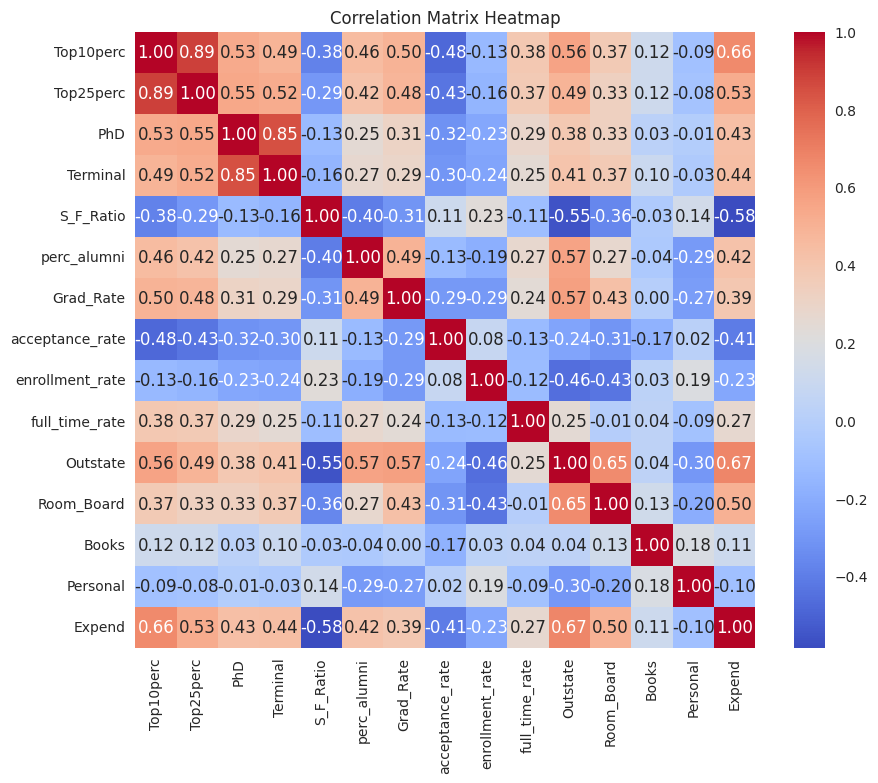

In [0]:
# Correlation
investigator2 = Investigate_data(college_df_under_hund)

investigator.calculate_correlation(features)

For features exhibiting an absolute correlation value greater than 0.8 with another feature, one will be eliminated. Consequently, the feature "top10perc" will be removed as its values are encompassed within "top25perc." Similarly, "Terminal" will be dropped in favor of retaining "PhD."

In [0]:
college_df_cleaned = college_df_under_hund.drop('Terminal', 'Top10perc', 'Books')
float_cols = [item for item in float_cols if item not in {'Terminal', 'Top10perc'}]
int_cols = [item for item in int_cols if item not in {'Books'}]
features = float_cols + int_cols

In [0]:
data_pd = college_df_cleaned.toPandas()

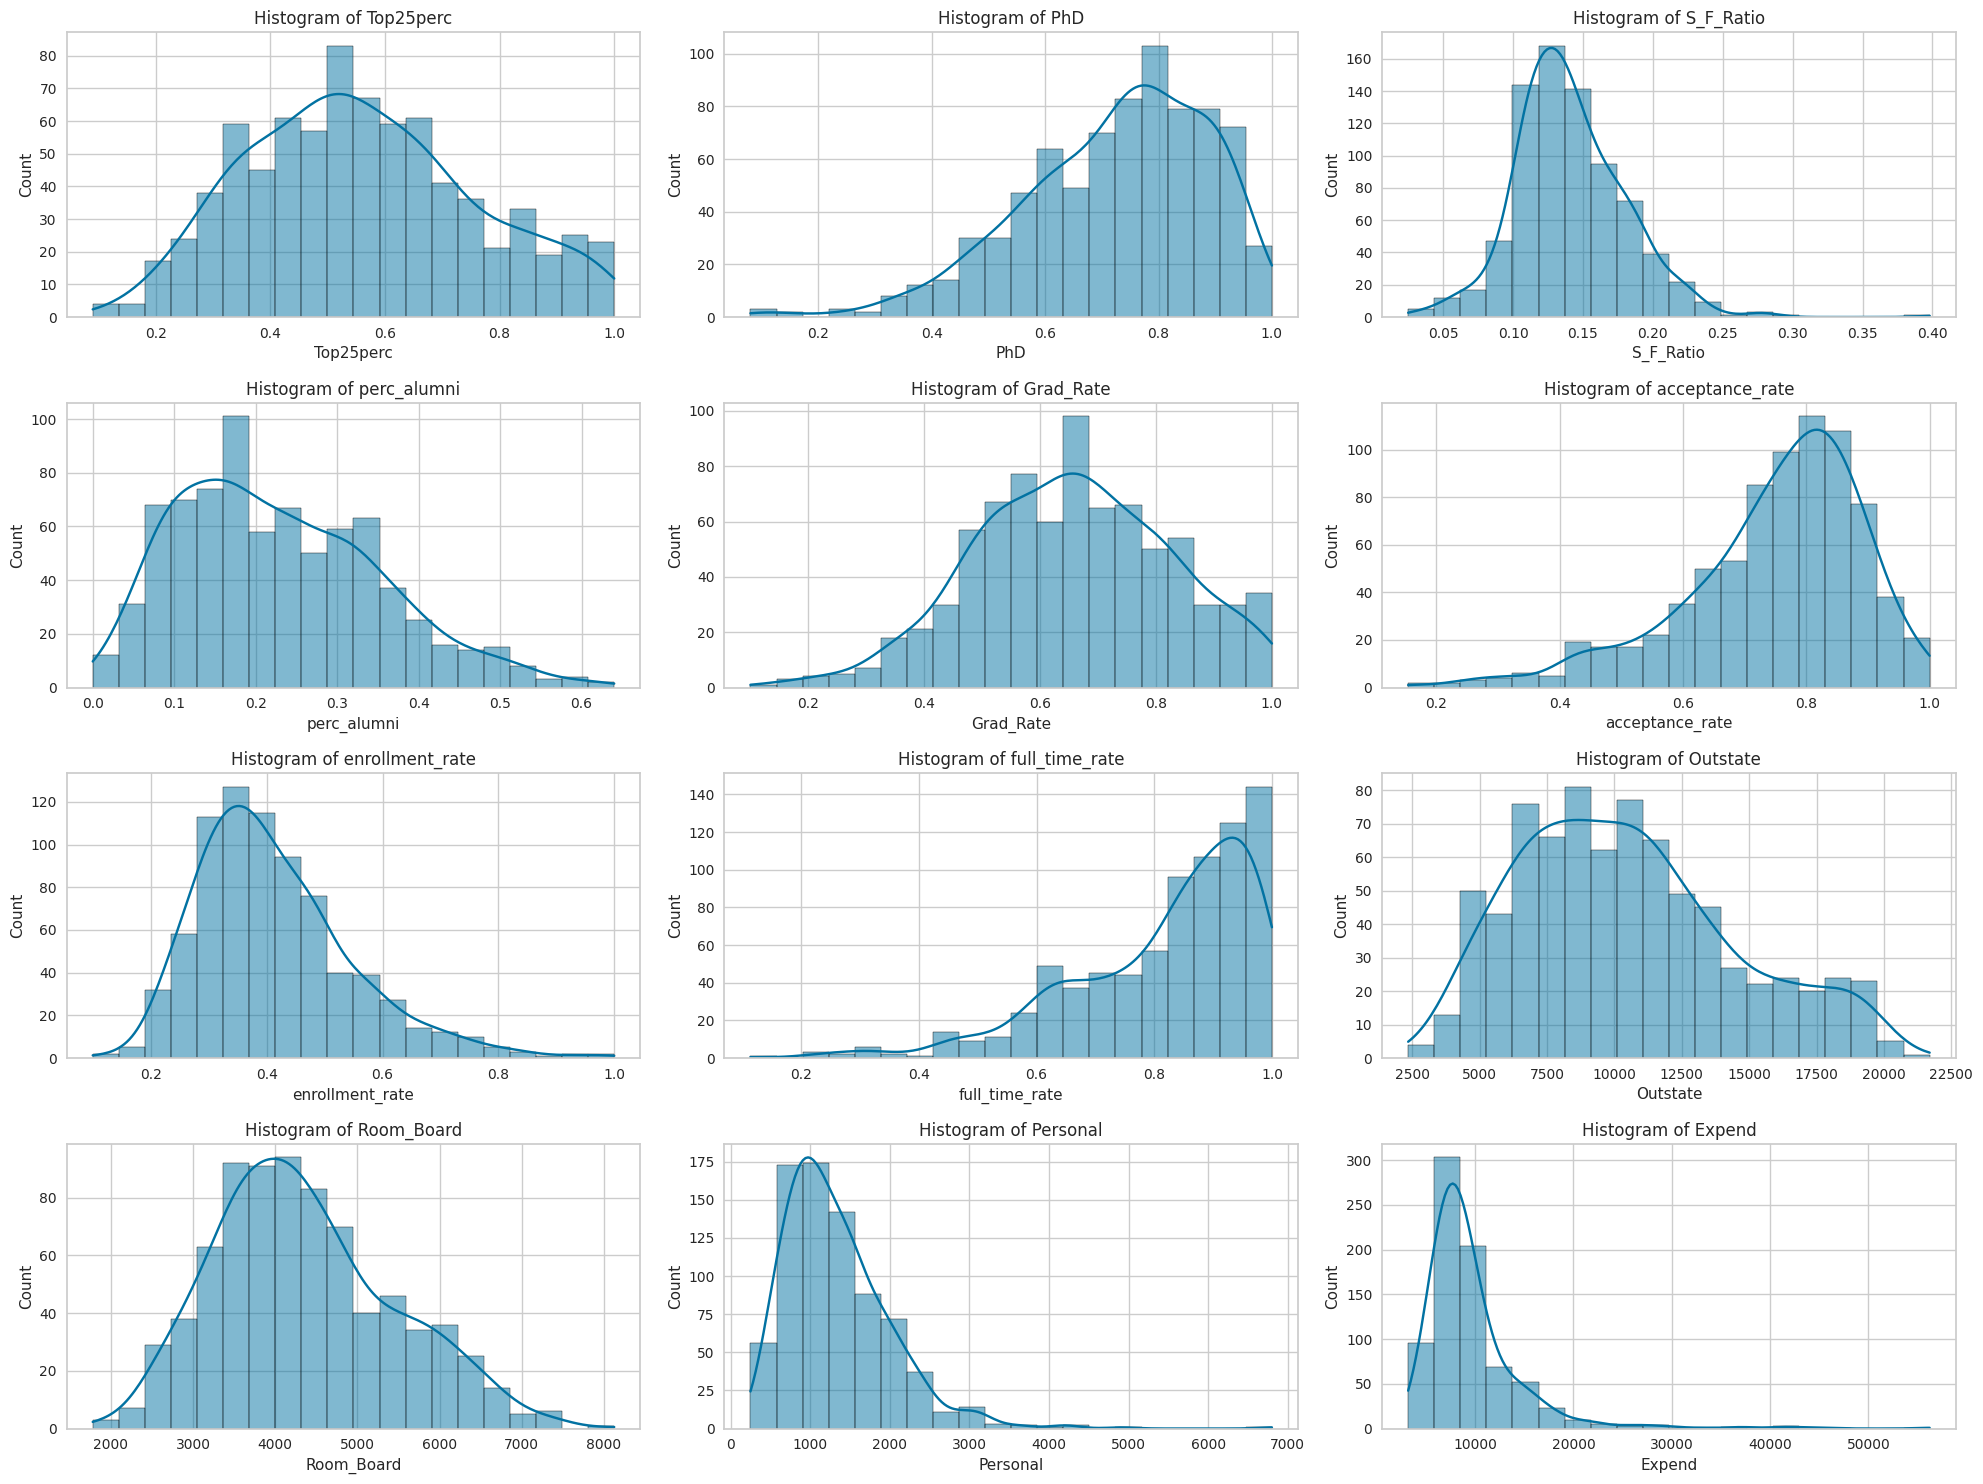

In [0]:
# Data with no transformations
Plot_Hist(features, data_pd)

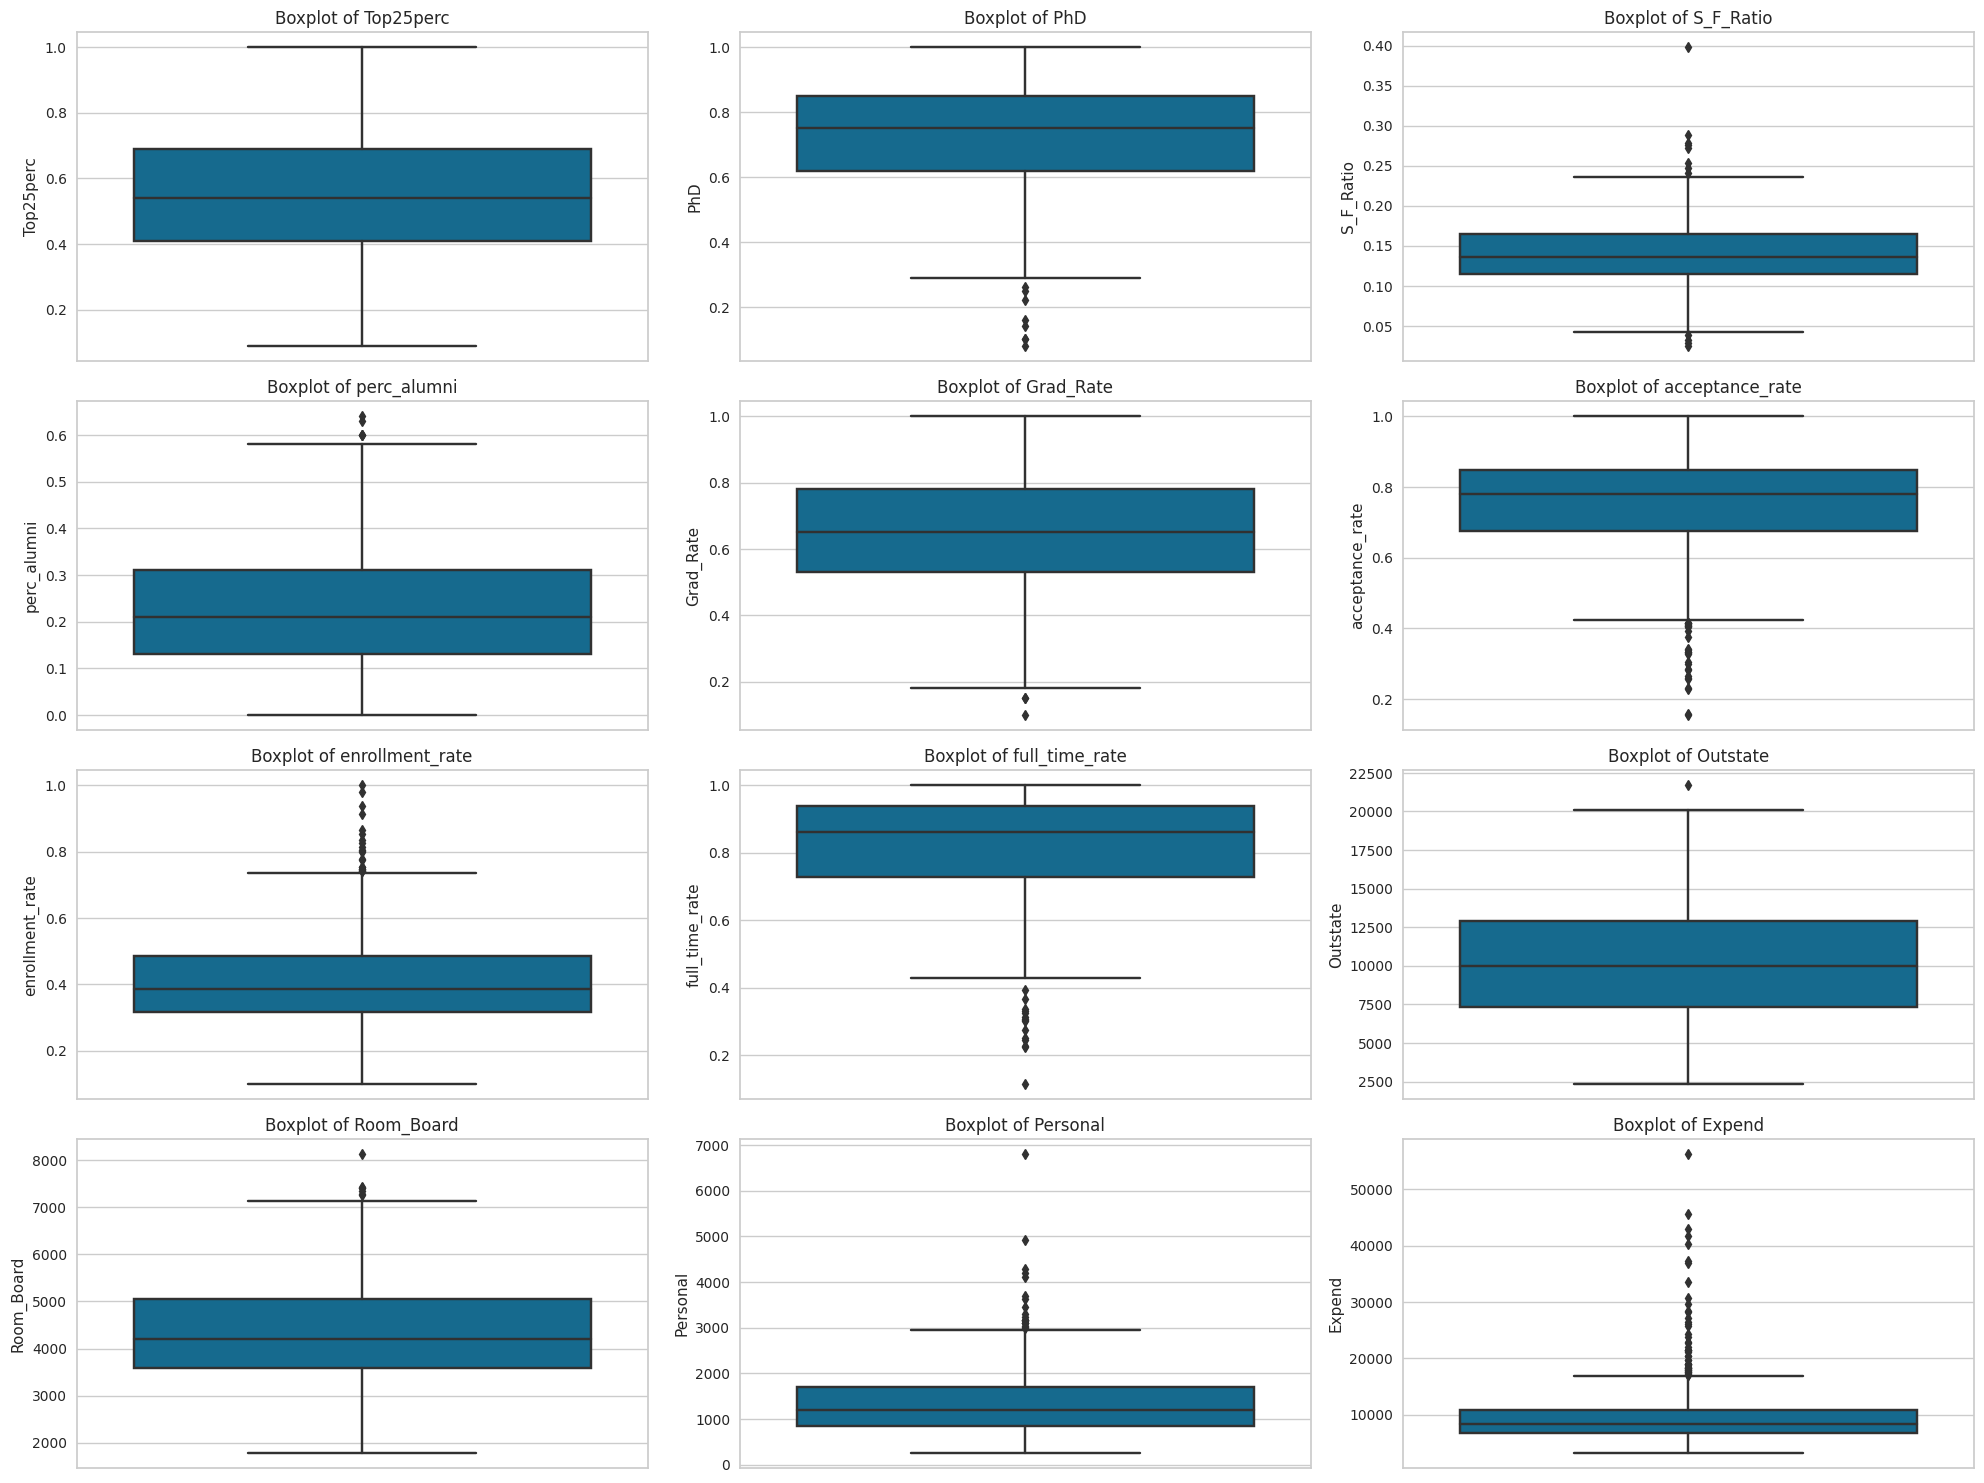

In [0]:
Plot_Box(features, data_pd)

In [0]:
# Use quanitle scaler as it is robust to outliers
input_data_pd = data_pd[features]
n_rows = len(input_data_pd)

quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=min(n_rows, 1000))
scaled_features = quantile_transformer.fit_transform(input_data_pd)

scaled_data_pd = pd.DataFrame(scaled_features, columns=features)

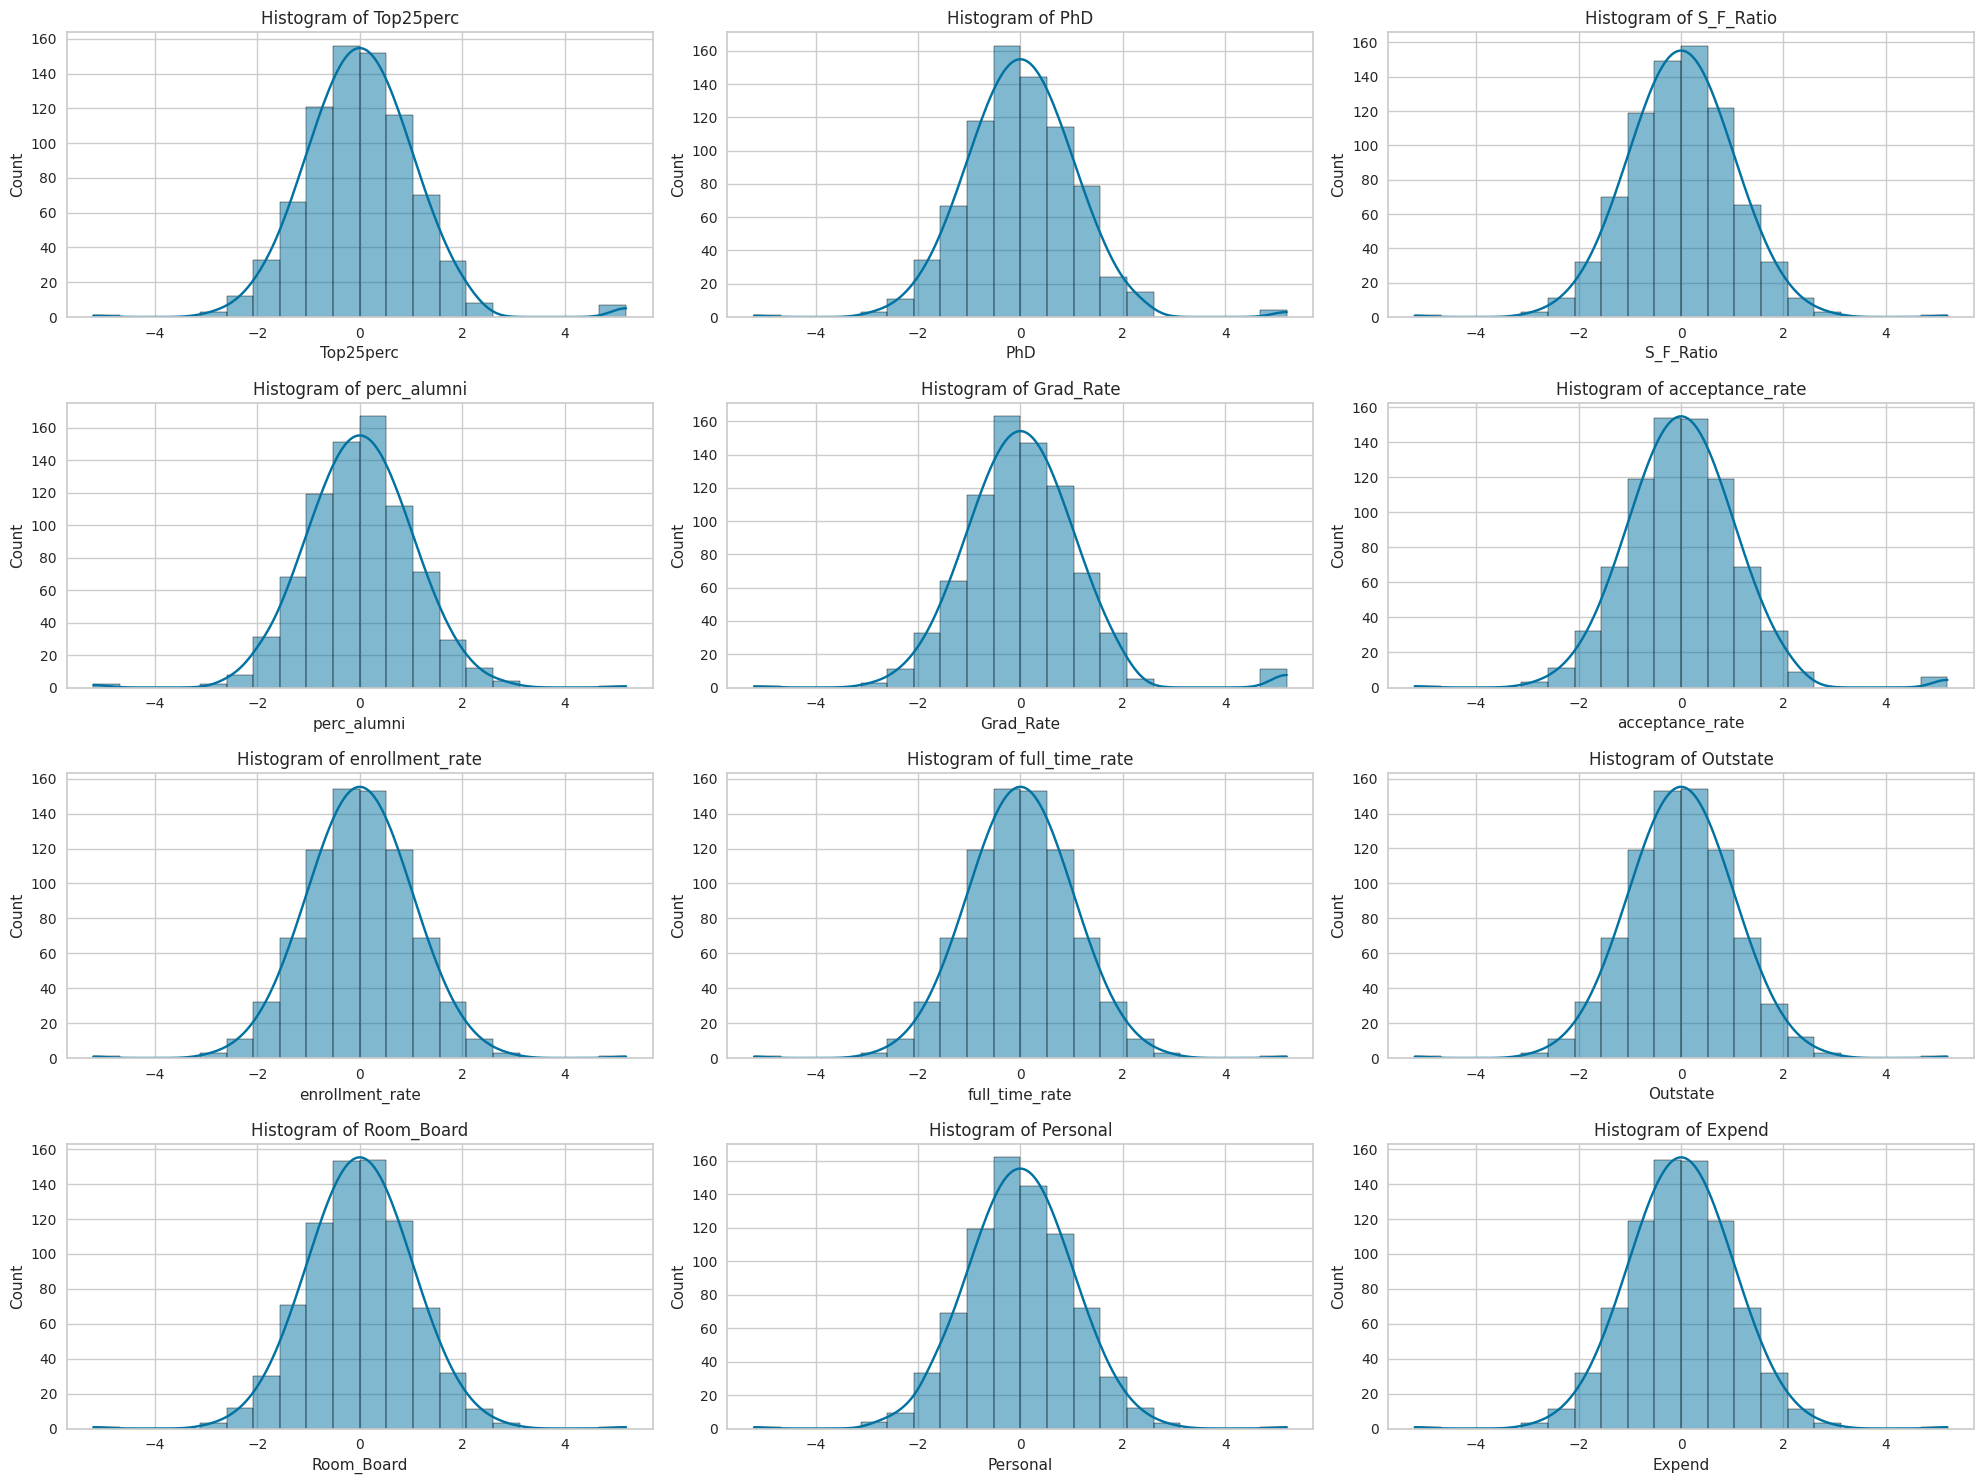

In [0]:
# Data after scaled
Plot_Hist(features, scaled_data_pd)

Outliers in the data have been handled. Now to determine the number of clusters within the data. PCA will be used to reduce the dimensions of the data before passing it through the KMeans algorithm. The threshold for PCA must be analyzed first.

In [0]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="threadpoolctl")

# Function to suppress stdout and stderr
@contextlib.contextmanager
def suppress_output():
    with open('/dev/null', 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [0]:
pca_thresholds = [0.7, 0.8, 0.9]
num_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
import sys

silhouette_scores = {threshold: [] for threshold in pca_thresholds}

with suppress_output():
    for threshold in pca_thresholds:
        pca = PCA(n_components=threshold)
        pca_features = pca.fit_transform(scaled_data_pd)

        normalizer = Normalizer()
        normalized_features = normalizer.fit_transform(pca_features)

        for k in num_clusters:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(normalized_features)

            silhouette_avg = silhouette_score(normalized_features, cluster_labels)
            silhouette_scores[threshold].append(silhouette_avg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

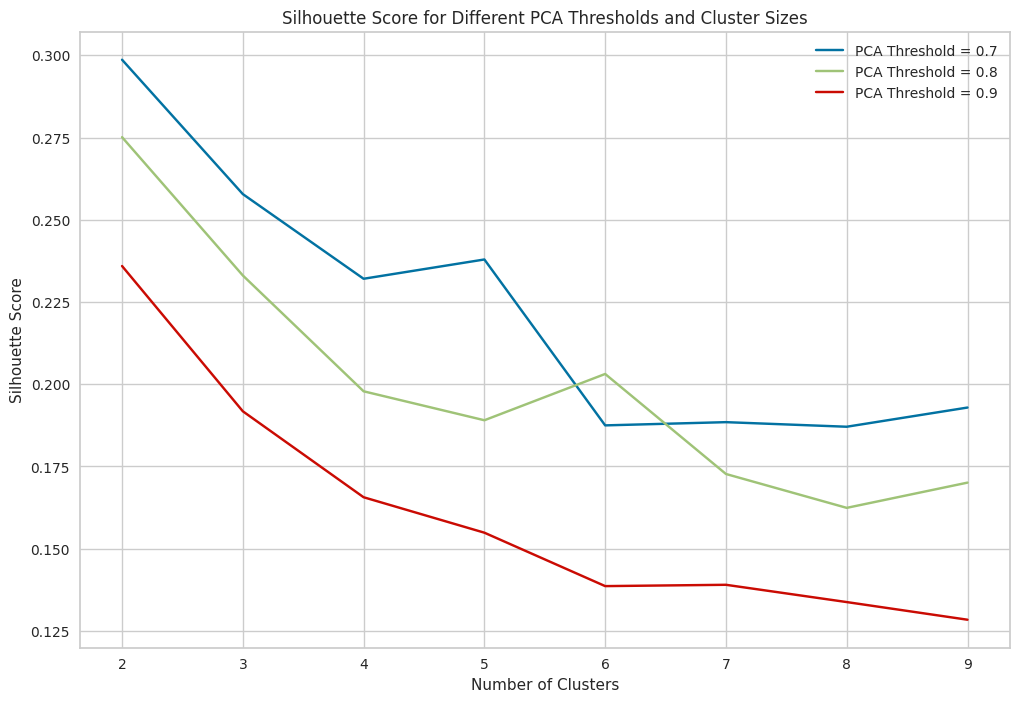

In [0]:
plt.figure(figsize=(12, 8))
for threshold in pca_thresholds:
    plt.plot(num_clusters, silhouette_scores[threshold], label=f'PCA Threshold = {threshold}')
    
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different PCA Thresholds and Cluster Sizes')
plt.legend()
plt.grid(True)
plt.show()

There needs to be a balance between the ratio of the variance explained by the PCA transformation and the value of the silhouette score. We want a high silhouette score and a high ratio of variance explained. A silhouette score above 0.2 is considered ideal. With a PCA threshold of 0.8 and a cluster size of 6, a silhouette score exceeding 0.2 is achieved. Thus, these values will be used for the analysis.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

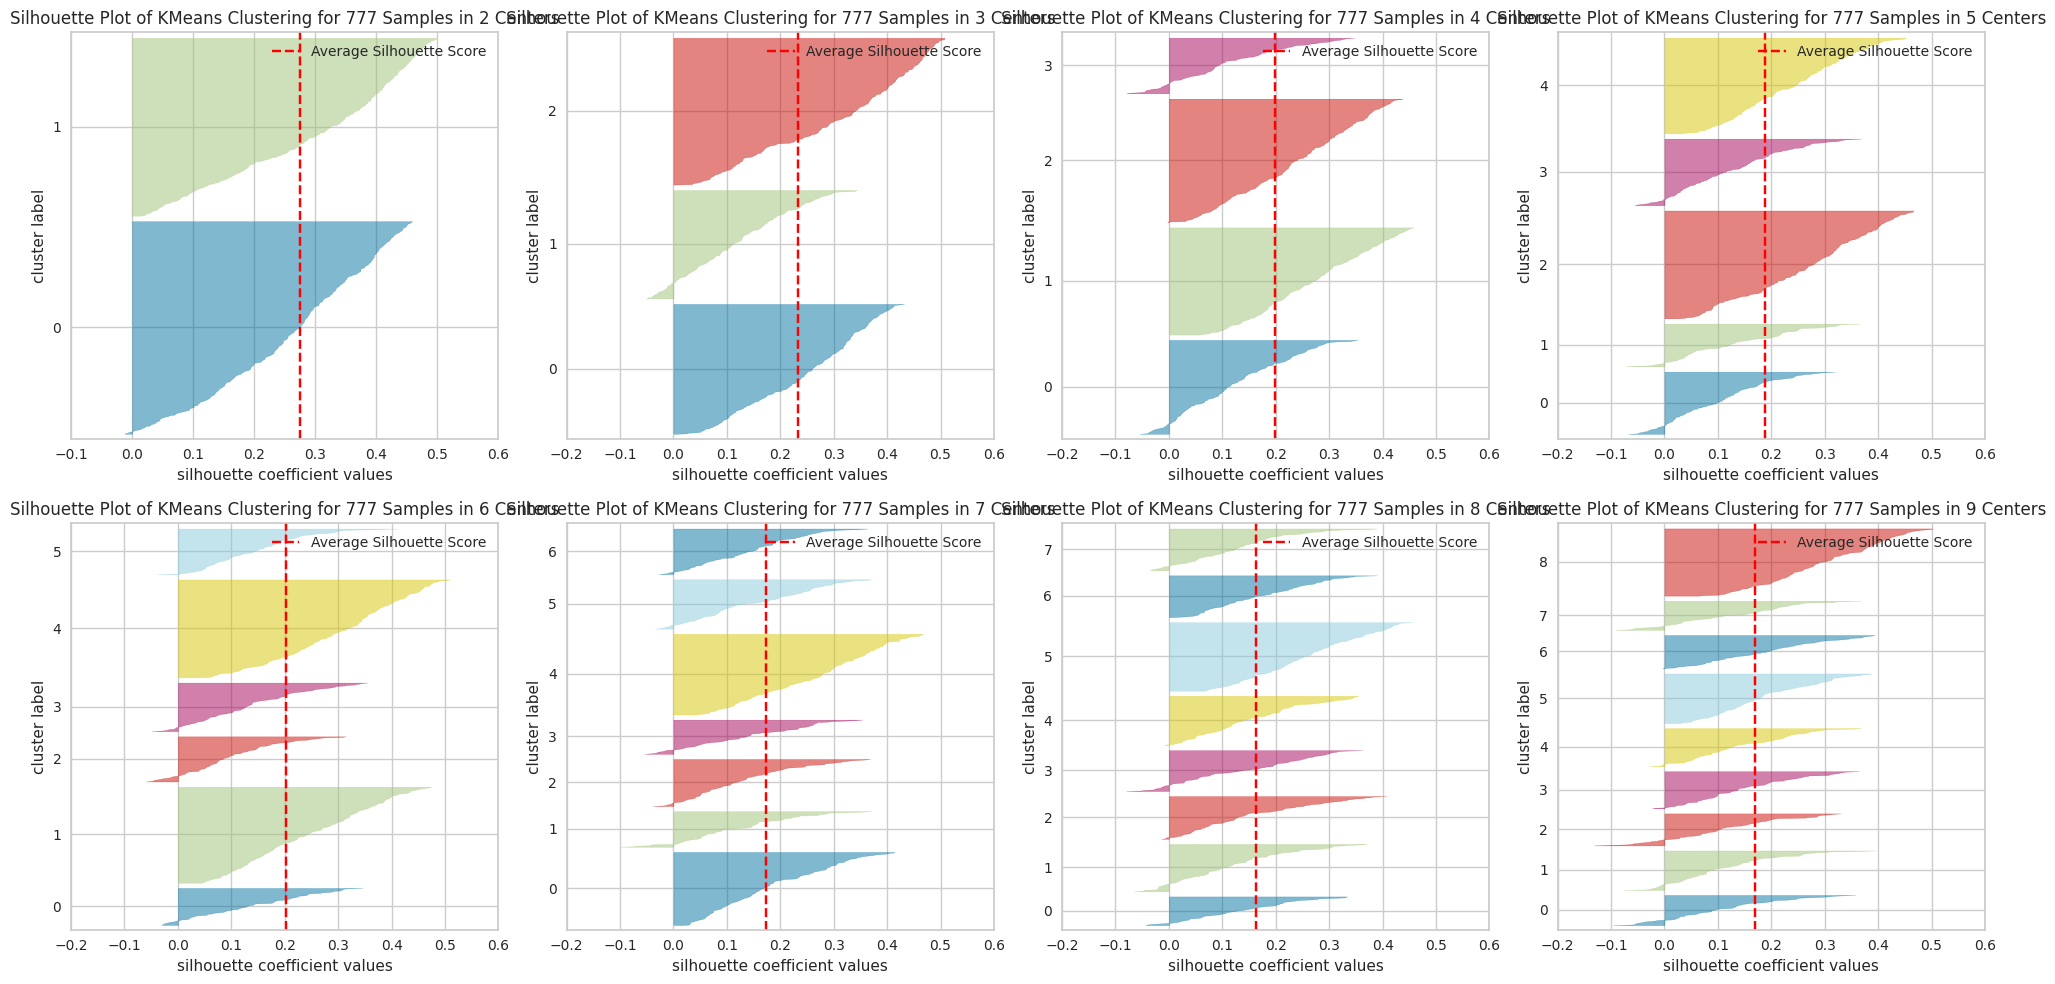

In [0]:
# Create silhouette plots for different cluster sizes
thres = 0.8

with suppress_output():
    pca = PCA(n_components=0.8)
    pca_features = pca.fit_transform(scaled_features)

    # Normalize the pca components
    normalizer = Normalizer()
    normalized_features = normalizer.fit_transform(pca_features)

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for k, ax in zip(range(2, 10), axes):
        kmeans = KMeans(n_clusters=k, random_state=42)
        visualizer = SilhouetteVisualizer(kmeans, ax=ax, colors='yellowbrick')
        visualizer.fit(normalized_features)
        visualizer.finalize()

    plt.tight_layout()
    plt.show()

In [0]:
optimal_clusters = 6
with suppress_output():
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_features)
    data_pd["Cluster"] = cluster_labels

    # Combine all dataframes
    scaled_pandas_df = pd.DataFrame(scaled_features, columns=[f"{col}_scaled" for col in features])
    pca_columns = [f"PC{i+1}" for i in range(pca_features.shape[1])]
    pca_pandas_df = pd.DataFrame(pca_features, columns=pca_columns)
    normalized_pca_columns = [f"Norm_PC{i+1}" for i in range(normalized_features.shape[1])]
    normalized_pca_pandas_df = pd.DataFrame(normalized_features, columns=normalized_pca_columns)
    combined_df = pd.concat([data_pd, scaled_pandas_df, pca_pandas_df, normalized_pca_pandas_df], axis=1)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

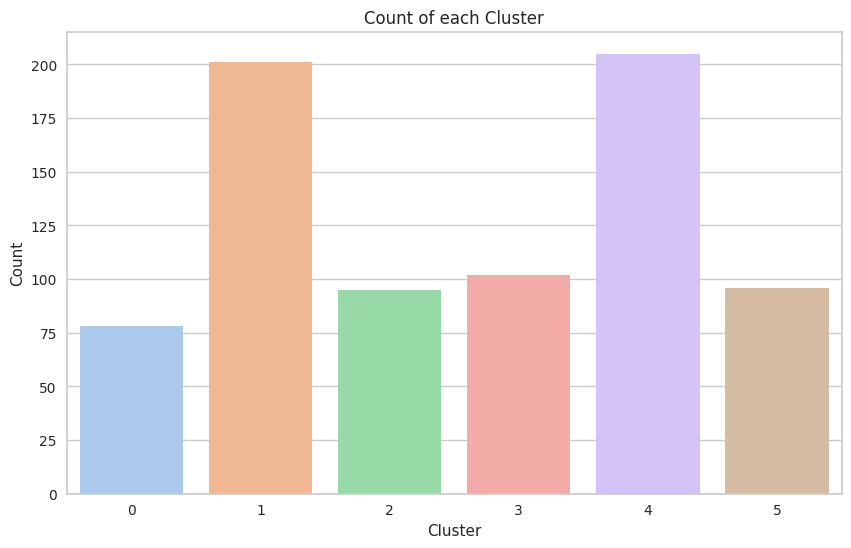

In [0]:
plt.rcParams["font.family"] = "DejaVu Sans"

plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=data_pd, palette='pastel')
plt.title('Count of each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

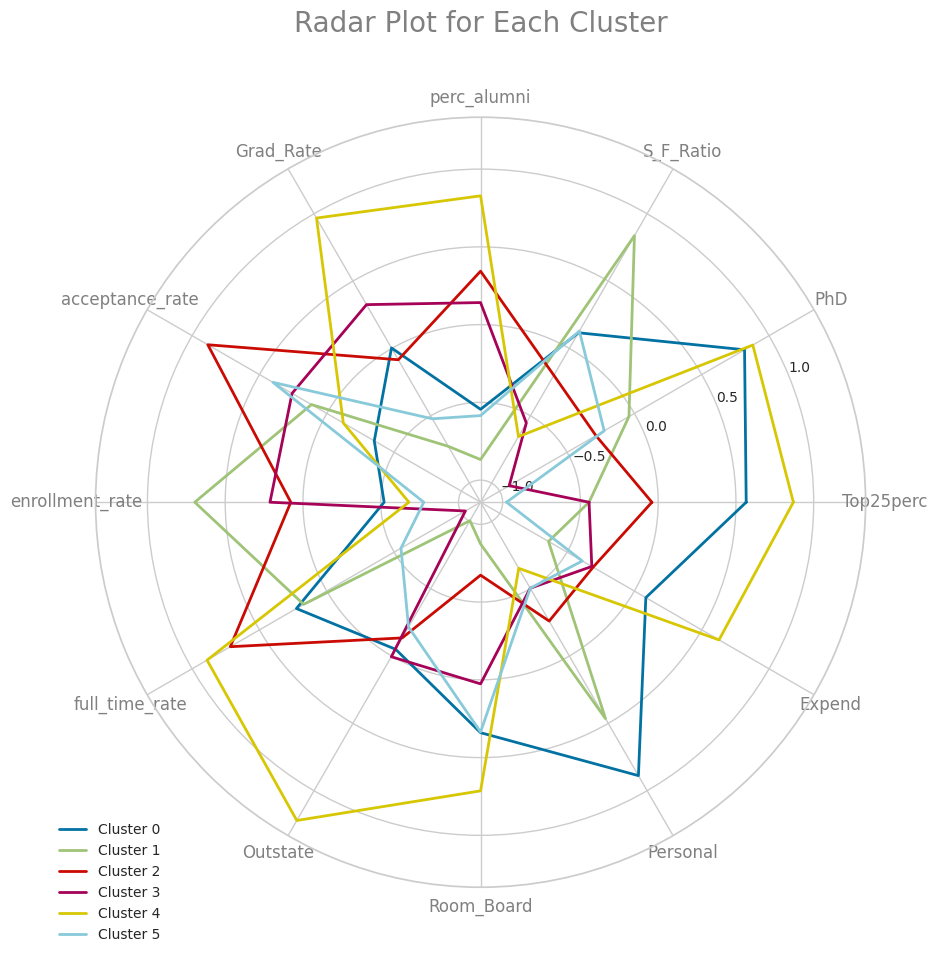

In [0]:
from sklearn.preprocessing import StandardScaler
from math import pi


scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_pd[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)

# Calculate the median values for each feature within each cluster
cluster_medians = scaled_df.groupby(data_pd["Cluster"]).median()

# Number of clusters and features
num_clusters = cluster_medians.shape[0]
num_features = len(features)

# Create the radar plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
plt.rcParams["font.family"] = "DejaVu Sans"

# Define the angles for the radar plot
angles = [n / float(num_features) * 2 * pi for n in range(num_features)]
angles += angles[:1]

# Plot data for each cluster
for i in range(num_clusters):
    values = cluster_medians.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')

# Add feature labels to the radar plot
plt.xticks(angles[:-1], features, color='grey', size=12)

# Add a title and legend
plt.title('Radar Plot for Each Cluster', size=20, color='grey', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

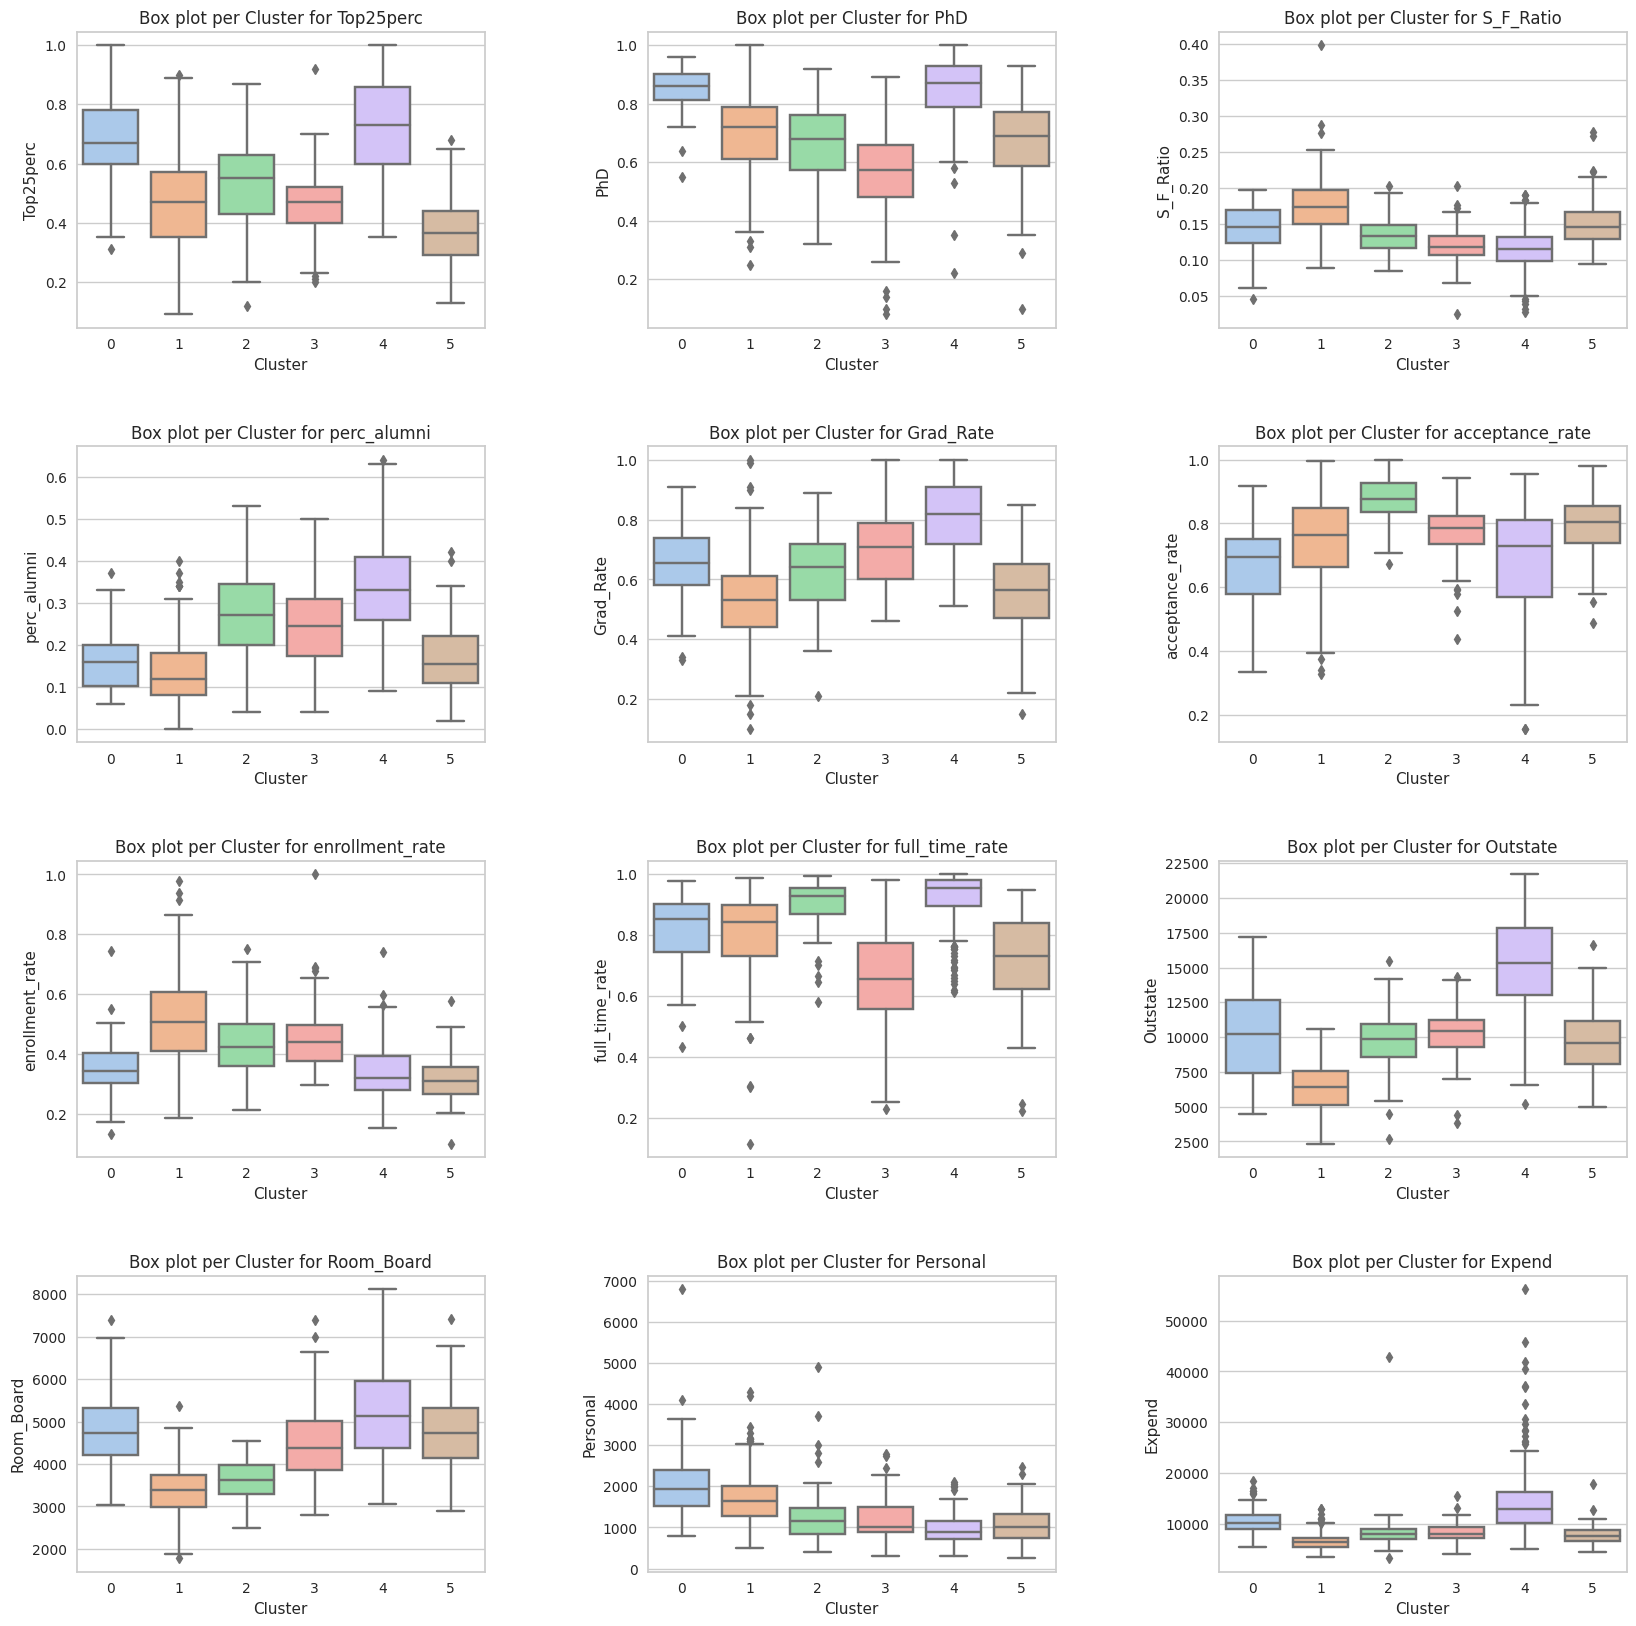

In [0]:
# Box plots to investigate the difference in features per cluster
plt.rcParams["font.family"] = "DejaVu Sans"

fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

for ax, feat in zip(axes, features):
    sns.boxplot(data=data_pd, x='Cluster', y=feat, palette='pastel', ax=ax)
    ax.set_title(f'Box plot per Cluster for {feat}')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feat)

for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.show()

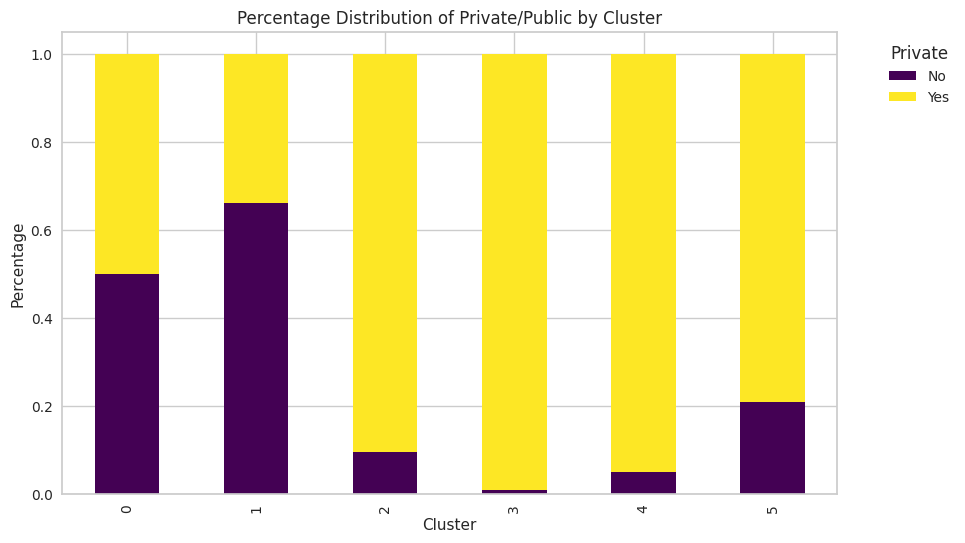

In [0]:
# Create a stacked bar plot demonstrating the percentage of private colleges in each cluster
private_counts = data_pd.groupby(['Cluster', 'Private']).size().unstack(fill_value=0)
private_percentages = private_counts.div(private_counts.sum(axis=1), axis=0)

private_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

plt.rcParams["font.family"] = "DejaVu Sans"
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Private/Public by Cluster')
plt.legend(title='Private', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

###Cluster 0: "Elite Scholars"
Colleges in this cluster attract highly qualified students (top 25% of their high school class) and have high instructional expenditures, a high percentage of faculty with PhDs, and high personal spending. The low acceptance rate indicates selectivity.

###Cluster 1: "Economical Public Colleges"
This cluster represents colleges with a high enrollment rate and personal spending but low out-of-state tuition, alumni donations, graduation rate, instructional expenditure, and room and board costs. They also have a high student-to-faculty ratio. These institutions may be more accessible and economical, likely appealing to in-state students.

###Cluster 2: "Inclusive Private Colleges"
This cluster includes colleges with high full-time enrollment, acceptance rates, and alumni donation percentages. They have low room and board costs and a significant number of private colleges. These colleges emphasize community and accessibility.

###Cluster 3: "Small Private Colleges"
Colleges in this cluster have high graduation rates but low full-time enrollment, faculty with PhDs, and student-to-faculty ratios. They have a high percentage of private colleges, indicating a focus on student achievement and smaller class sizes.

###Cluster 4: "Prestigious Private Universities"
This cluster comprises colleges with high out-of-state tuition, full-time enrollment, room and board costs, graduation rates, alumni donations, PhDs among faculty, instructional expenditures, and top 25% high school students. They have low personal spending, enrollment rates, and student-to-faculty ratios, with a high proportion of private colleges. These colleges are likely prestigious and well-funded.

###Cluster 5: "Fall Back Colleges"
Colleges in this cluster have high acceptance rates but low percentages of top 25% high school students, instructional expenditures, enrollment rates, and graduation rates. These institutions are likely more accessible and have lower selectivity.